In [1]:
import baostock as bs
import pandas as pd

# 登陆系统
lg = bs.login()

# 获取沪深A股历史K线数据
rs = bs.query_history_k_data_plus("sh.000001",
    "date,open,high,low,close,volume",
    start_date='2024-01-01', end_date='2024-04-20',
    frequency="d", adjustflag="3")

# 输出结果
data_list = []
while (rs.error_code == '0') & rs.next():
    # 获取一条记录，将记录合并在一起
    data_list.append(rs.get_row_data())
result = pd.DataFrame(data_list, columns=rs.fields)

# 退出系统
bs.logout()


login success!
logout success!


In [5]:
import numpy as np

result.rename(columns={"date": "datetime"}, inplace=True)
result['datetime'] = pd.to_datetime(result['datetime'], format = '%Y-%m-%d')
result.index = pd.to_datetime(result.index)
collist = result.columns.tolist()
result[collist[1:]] = pd.DataFrame(result[collist[1:]], dtype=np.float)
result.set_index('datetime')

,open,high,low,close,volume
datetime,,,,,
2024-01-02,2972.7750,2976.2682,2962.2762,2962.2762,3.041418e+10
2024-01-03,2957.1117,2971.2834,2953.2901,2967.2472,2.854559e+10
2024-01-04,2965.5087,2966.6828,2936.6347,2954.3486,2.649809e+10
2024-01-05,2949.8221,2967.9677,2916.7206,2929.1833,3.010402e+10
2024-01-08,2923.4570,2924.4559,2887.5379,2887.5379,2.702751e+10
...,...,...,...,...,...
2024-04-15,3013.6722,3066.9412,2995.5420,3057.3776,4.612392e+10
2024-04-16,3043.5505,3052.4346,3005.3400,3007.0681,4.480705e+10
2024-04-17,3008.0614,3071.3806,3002.0564,3071.3806,4.133584e+10


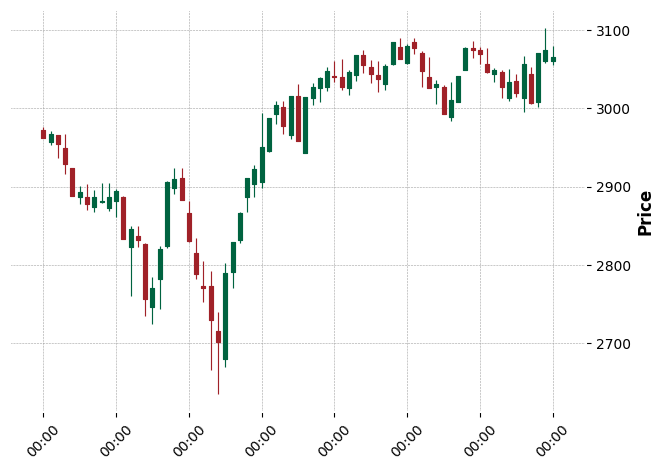

In [6]:
import mplfinance as mpf

mpf.plot(result, type='candle', style='charles')

In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import baostock as bs
from pathlib import Path
from dateutil import parser
from datetime import timedelta

In [4]:

class BaoStockData:
 
    def __init__(self, code, fields, start_date, end_date, frequency="5", adjustflag="2"):
        self.code = code
        self.fields = fields
        self.start_date = start_date
        self.end_date = end_date
        self.frequency = frequency
        self.adjustflag = adjustflag
 
        BASE_DIR = Path(__file__).resolve().parent
        bar_path = f"results/{self.code}_5m_{datetime.date.today()}.csv"
        tick_path = f"results/{self.code}_ticks_{datetime.date.today()}.csv"
        bar_path_excel = f"results/{self.code}_5m_{datetime.date.today()}.xlsx"
 
        self.bar_path = os.path.join(BASE_DIR, bar_path)
        self.bar_path_excel = os.path.join(BASE_DIR, bar_path_excel)
        self.tick_path = os.path.join(BASE_DIR, tick_path)
 
    def get_data_from_baostock(self):
        # === 登陆系统 ===
        lg = bs.login()
        # 显示登陆返回信息
        print('login respond error_code:' + lg.error_code)
        print('login respond  error_msg:' + lg.error_msg)
 
        # === 获取沪深A股历史K线数据 ===
        # 详细指标参数，参见“历史行情指标参数”章节；“分钟线”参数与“日线”参数不同。“分钟线”不包含指数。
        # 分钟线指标：date,time,code,open,high,low,close,volume,amount,adjustflag
        # 周月线指标：date,code,open,high,low,close,volume,amount,adjustflag,turn,pctChg
 
        if self.code.startswith("6"):  # 600036
            m = "sh"
        elif self.code.startswith("0", "3"):  # 000858
            m = "sz"
        else:
            m = ""
 
        params = {
            "code": f"{m}.{self.code}",
            "fields": self.fields,
            "start_date": self.start_date,  # '2024-01-01',
            "end_date": self.end_date,  # '2024-04-10',
            "frequency": self.frequency,  # d
            "adjustflag": self.adjustflag
        }
        rs = bs.query_history_k_data_plus(**params)
        print('query_history_k_data_plus respond error_code:' + rs.error_code)
        print('query_history_k_data_plus respond  error_msg:' + rs.error_msg)
 
        # === 打印结果集 ===
        data_list = []
        while (rs.error_code == '0') & rs.next():
            # 获取一条记录，将记录合并在一起
            data_list.append(rs.get_row_data())
        result = pd.DataFrame(data_list, columns=rs.fields)
 
        # ===
        result['time'] = [t[:-3] for t in result['time']]
        result['time'] = pd.to_datetime(result['time'])
        result.rename(columns={"time": "datetime"}, inplace=True)
 
        need_cols = ["datetime", "open", "high", "low", "close", "volume", "amount"]
        result = result.loc[:, need_cols]
        result.set_index("datetime", drop=True, inplace=True)
 
        # === 结果集输出到csv文件 ===
        result.to_csv(self.bar_path, index=True)
        result.to_excel(self.bar_path_excel, index=True)
        print(result)
 
        # === 登出系统 ===
        bs.logout()
 
    def get_ticks_for_backtesting(self):
        """
        get ticks for backtesting
        :tick_path: 生成的回测数据路径
        :param2 bar_path: 历史数据的tick路径
        :return:list, such as [(datetime, last_price), (datetime, last_price)]
        """
 
        if os.path.exists(self.tick_path):  # 如果已存在回测数据，直接读取回测数据ticks
            ticks = pd.read_csv(
                self.tick_path,
                parse_dates=['datetime'],
                index_col='datetime')
 
            tick_list = []
            for index, row in ticks.iterrows():
                tick_list.append((index, row[0]))
            ticks = tick_list
 
        else:
            bar_5m = pd.read_csv(self.bar_path)  # 使用pandas读取csv数据
            ticks = []
 
            for index, row in bar_5m.iterrows():  # 根据不同的开盘价设置步长
                if row['open'] < 30:
                    step = 0.01
                elif row['open'] < 60:
                    step = 0.03
                elif row['open'] < 90:
                    step = 0.05
                else:
                    step = 0.1
                # in case of np.arrange(30, 30.11, 0.02), (open, high, step)
                # we will not have 30.11 as the highest price,
                # we might not catch high when step is more than 0.01
                # that is why me need: arr = np.append(arr, row['high']) and
                #   arr = np.append(arr, row['low'])
                arr = np.arange(row['open'], row['high'], step)  # 按步长生成从open到high的数据
                arr = np.append(arr, row['high'])  # 这个是为了弥补步长的不对等会漏掉high
                arr = np.append(arr, np.arange(row['open'] - step, row['low'], -step))  # 按步长生成从open到low的数据
                arr = np.append(arr, row['low'])  # 这个是为了弥补步长的不对等会漏掉low
                arr = np.append(arr, row['close'])
 
                i = 0
                dt = parser.parse(row['datetime']) - timedelta(minutes=5)
                for item in arr:
                    ticks.append((dt + timedelta(seconds=0.1 * i), item))  # 将数据时间模拟到0.1秒递进
                    i += 1
            tick_df = pd.DataFrame(ticks, columns=['datetime', 'price'])
            tick_df.to_csv(self.tick_path, index=False)  # 保存到csv回测数据中
        return ticks
 
    def main(self):
 
        self.get_data_from_baostock()  # bar
        ticks = self.get_ticks_for_backtesting()  # ticket
        return ticks


In [5]:
if __name__ == '__main__':
    code1 = "600035"
    # code2 = "000858"
    # code3 = "300750"
    fields_5 = "date,time,code,open,high,low,close,volume,amount,adjustflag"
    fields_d = "date,code,open,high,low,close,preclose,volume,amount,adjustflag,turn,tradestatus,pctChg,isST"
    bsd = BaoStockData(code1, fields_5, '2024-01-01', '2024-04-10')
    bsd.main()

NameError: name '__file__' is not defined